# 03 — Logistic Regression Model  
Hotel Booking Demand (Cancellation Prediction)

## Notebook purpose
This notebook develops a strong supervised baseline using **Logistic Regression** and demonstrates:
- leakage-safe end-to-end modeling using `sklearn.Pipeline` (`preprocessing → model`)
- hyperparameter tuning using stratified cross-validation
- test-set evaluation using multiple metrics and diagnostic plots
- interpretability using coefficient analysis on transformed features

## Inputs
- Preferred: `data/processed/hotel_bookings_dedup.csv`
- Fallback: `data/raw/hotel_bookings.csv`

## Outputs (overwritten on each run)
- Model:
  - `artifacts/models/logreg_pipeline.joblib`
- Metrics:
  - `artifacts/metrics/logreg_cv_results.csv`
  - `artifacts/metrics/logreg_best_params.json`
  - `artifacts/metrics/logreg_test_metrics.json`
  - `artifacts/metrics/logreg_threshold_metrics.csv`
  - `artifacts/metrics/logreg_coefficients_top.csv`
- Plots:
  - `artifacts/plots/logreg_confusion_matrix.png`
  - `artifacts/plots/logreg_roc_curve.png`
  - `artifacts/plots/logreg_pr_curve.png`
  - `artifacts/plots/logreg_threshold_f1.png`
  - `artifacts/plots/logreg_threshold_precision_recall.png`
  - `artifacts/plots/logreg_coefficients_positive.png`
  - `artifacts/plots/logreg_coefficients_negative.png`
- Reports:
  - `artifacts/reports/logreg_classification_report.txt`
  - `artifacts/reports/logreg_notes.md`
  - `artifacts/reports/run_metadata.json`

All preprocessing steps are fitted on training folds only (no leakage).


In [62]:
# Repository bootstrap (fixes ModuleNotFoundError: 'src')
# The repository root is resolved quickly using Git when available.
# A bounded parent-directory scan is used as a fallback.

import os
import sys
import subprocess
from pathlib import Path

def _find_repo_root(max_levels: int = 25) -> Path:
    try:
        out = subprocess.check_output(
            ["git", "rev-parse", "--show-toplevel"],
            stderr=subprocess.DEVNULL,
            text=True,
        ).strip()
        p = Path(out)
        if (p / "src").is_dir():
            return p
    except Exception:
        pass

    cwd = Path.cwd()
    for p in [cwd] + list(cwd.parents)[:max_levels]:
        if (p / "src").is_dir():
            return p

    raise FileNotFoundError(
        "Folder 'src' was not found within the parent directories. "
        "Open the repository root folder in VS Code and rerun the notebook."
    )

root = _find_repo_root(max_levels=25)
os.chdir(root)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

print("Working directory:", Path.cwd())
print("Python path entry added:", root)


Working directory: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment
Python path entry added: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment


## Imports and configuration fallback

`src.config` may differ between group members during active development.
To prevent notebook failures, configuration values are loaded with safe fallbacks.


In [63]:
import platform
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
)

try:
    from tqdm.auto import tqdm
except Exception:
    raise ImportError("Package 'tqdm' is required. Install with: pip install tqdm")

from src.io_utils import ensure_artifact_dirs, save_json, save_text, save_dataframe, save_model, save_run_metadata
from src.data_loader import load_hotel_bookings, basic_train_ready_checks
from src.preprocessing import build_preprocessor, PreprocessOptions

warnings.filterwarnings("ignore", category=UserWarning)

# --- Safe config loading (no ImportError if a field is missing) ---
import src.config as cfg

PROJECT_NAME = getattr(cfg, "PROJECT_NAME", "ML-assignment")
RANDOM_STATE = int(getattr(cfg, "RANDOM_STATE", 42))
TARGET_COL = getattr(cfg, "TARGET_COL", "is_canceled")
TEST_SIZE = float(getattr(cfg, "TEST_SIZE", 0.20))
CV_SPLITS = int(getattr(cfg, "CV_SPLITS", 5))
LEAKAGE_COLS = list(getattr(cfg, "LEAKAGE_COLS", ["reservation_status", "reservation_status_date"]))
DEFAULT_DATA_PATH = str(getattr(cfg, "DEFAULT_DATA_PATH", "data/raw/hotel_bookings.csv"))

# Optional (may not exist in some configs)
HIGH_CARDINALITY_COLS = list(getattr(cfg, "HIGH_CARDINALITY_COLS", ["agent", "company"]))
ONEHOT_MIN_FREQUENCY = getattr(cfg, "ONEHOT_MIN_FREQUENCY", 0.01)

# Parameter grid: use config if present, otherwise apply a strong default grid
PARAM_GRIDS = getattr(cfg, "PARAM_GRIDS", {}) or {}

ART = ensure_artifact_dirs("artifacts")

meta_path = save_run_metadata(
    {
        "project": PROJECT_NAME,
        "random_state": RANDOM_STATE,
        "test_size": TEST_SIZE,
        "cv_splits": CV_SPLITS,
        "target_col": TARGET_COL,
        "notebook": "03_model_logreg.ipynb",
        "python_version": sys.version,
        "platform": platform.platform(),
    },
    base_dir="artifacts",
    repo_root=".",
)
print("Metadata file:", meta_path.resolve())
print("Artifacts base:", ART["base"].resolve())

display(pd.DataFrame([{
    "PROJECT_NAME": PROJECT_NAME,
    "RANDOM_STATE": RANDOM_STATE,
    "TEST_SIZE": TEST_SIZE,
    "CV_SPLITS": CV_SPLITS,
    "TARGET_COL": TARGET_COL,
    "ONEHOT_MIN_FREQUENCY": ONEHOT_MIN_FREQUENCY,
    "LEAKAGE_COLS": ", ".join(LEAKAGE_COLS),
    "HIGH_CARDINALITY_COLS": ", ".join(HIGH_CARDINALITY_COLS),
}]))


# Reduce warning noise during cross-validation
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r".*'penalty' was deprecated.*",
)


Metadata file: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\reports\run_metadata.json
Artifacts base: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts


,PROJECT_NAME,RANDOM_STATE,TEST_SIZE,CV_SPLITS,TARGET_COL,ONEHOT_MIN_FREQUENCY,LEAKAGE_COLS,HIGH_CARDINALITY_COLS
0,ML-assignment,42,0.2,5,is_canceled,0.01,"reservation_status, reservation_status_date","agent, company"


## Dataset loading

The processed dataset is preferred when available to standardize rows across the team.


In [64]:
preferred_processed = Path("data/processed/hotel_bookings_dedup.csv")
preferred_raw = Path(DEFAULT_DATA_PATH)

dataset_path = preferred_processed if preferred_processed.exists() else preferred_raw
if not dataset_path.exists():
    raise FileNotFoundError("Dataset not found. Expected at data/raw/hotel_bookings.csv")

print("Dataset path:", dataset_path.resolve())

df = load_hotel_bookings(dataset_path, drop_duplicates=False, verbose=True)
basic_train_ready_checks(df, target_col=TARGET_COL)

display(df.head())
display(pd.DataFrame({"rows": [df.shape[0]], "columns": [df.shape[1]]}))


Dataset path: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\data\processed\hotel_bookings_dedup.csv


[data_loader] Loaded shape: (87396, 32)
[data_loader] Columns: 32


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


,rows,columns
0,87396,32


## Type safety for identifier-like columns

Columns such as `agent` and `company` represent identifiers.
Casting them to string avoids implying a numeric ordering and supports one-hot encoding.


In [65]:
df_model = df.copy()
converted = []
for c in HIGH_CARDINALITY_COLS:
    if c in df_model.columns:
        # Preserve missingness explicitly as a category label
        df_model[c] = pd.to_numeric(df_model[c], errors="coerce").astype("Int64").astype("string")
        df_model[c] = df_model[c].fillna("MISSING")
        converted.append(c)

display(pd.DataFrame({"converted_to_string": converted}))
if converted:
    display(df_model[converted].head())


,converted_to_string
0,agent
1,company


,agent,company
0,MISSING,MISSING
1,MISSING,MISSING
2,MISSING,MISSING
3,304,MISSING
4,240,MISSING


## Train/test split

A stratified split preserves cancellation rate in both partitions.
Split metadata and label distributions are displayed and saved.


In [66]:
X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

split_info = {
    "n_rows_total": int(len(df_model)),
    "n_train": int(len(X_train)),
    "n_test": int(len(X_test)),
    "test_size": float(TEST_SIZE),
    "random_state": int(RANDOM_STATE),
    "stratified": True,
}
save_json(split_info, ART["data"] / "train_test_split_logreg.json")

train_dist = y_train.value_counts().rename_axis("label").reset_index(name="count")
train_dist["rate"] = train_dist["count"] / train_dist["count"].sum()
test_dist = y_test.value_counts().rename_axis("label").reset_index(name="count")
test_dist["rate"] = test_dist["count"] / test_dist["count"].sum()

display(pd.DataFrame([split_info]))
display(train_dist)
display(test_dist)

print("Saved:", (ART["data"] / "train_test_split_logreg.json").resolve())


,n_rows_total,n_train,n_test,test_size,random_state,stratified
0,87396,69916,17480,0.2,42,True


,label,count,rate
0,0,50696,0.725099
1,1,19220,0.274901


,label,count,rate
0,0,12675,0.725114
1,1,4805,0.274886


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\data\train_test_split_logreg.json


## Pipeline definition (preprocessing → model)

The pipeline uses the shared preprocessing builder to ensure:
- leakage columns are removed before modeling
- missing values are imputed
- categorical variables are one-hot encoded
- numeric variables are scaled (important for Logistic Regression)

The Logistic Regression solver is selected to support both L1 and L2 regularization.


In [67]:
pre_opts = PreprocessOptions(
    output_sparse=True,
    scale_numeric=True,
    onehot_min_frequency=ONEHOT_MIN_FREQUENCY,
    lower_clip_q=0.01,
    upper_clip_q=0.99,
)

preprocess = build_preprocessor(drop_cols=LEAKAGE_COLS, options=pre_opts)

logreg = LogisticRegression(
    solver="saga",
    max_iter=2000,
    random_state=RANDOM_STATE,
)

pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", logreg),
])

pipeline


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('features', ...), ('transform', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,drop_cols,"['reservation_status', 'reservation_status_date']"
,force_categorical_cols,[]
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to 

## Hyperparameter tuning with stratified cross-validation

Selection metric:
- **F1 score**, to balance precision and recall under class imbalance.

Tuning dimensions:
- `C`: regularization strength
- `penalty`: L1 vs L2
- `class_weight`: optional balancing

A manual grid search is used to provide progress visibility.


In [68]:
import sklearn
from packaging.version import Version

sk_ver = Version(sklearn.__version__)
print("scikit-learn version:", sklearn.__version__)

# Parameter grid selection avoids deprecated 'penalty' usage where applicable.
# - Newer scikit-learn versions recommend using l1_ratio instead of penalty switches.
# - Older versions require penalty='elasticnet' to enable l1_ratio.

default_grid = {
    "model__C": [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0],
    "model__l1_ratio": [0.0, 0.5, 1.0],   # 0.0≈L2, 1.0≈L1, 0.5=Elastic Net mix
    "model__class_weight": [None, "balanced"],
}

# Use config grid if defined; otherwise use the default grid above.
param_grid = PARAM_GRIDS.get("logreg", default_grid)

# If the config grid still contains deprecated keys, drop them safely.
for bad_key in ["model__penalty"]:
    if isinstance(param_grid, dict) and bad_key in param_grid:
        param_grid = dict(param_grid)
        param_grid.pop(bad_key)

grid = list(ParameterGrid(param_grid))

display(pd.DataFrame(grid))
print("Parameter combinations:", len(grid))


scikit-learn version: 1.8.0


,model__C,model__class_weight,model__max_iter,model__solver
0,0.1,NaN,2000,liblinear
1,0.1,balanced,2000,liblinear
2,1.0,NaN,2000,liblinear
3,1.0,balanced,2000,liblinear
4,10.0,NaN,2000,liblinear
5,10.0,balanced,2000,liblinear


Parameter combinations: 6


In [69]:
import sklearn
from packaging.version import Version

sk_ver = Version(sklearn.__version__)

cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

def make_fresh_pipeline() -> Pipeline:
    """Create a fresh preprocessing→model pipeline for each fit.

    This avoids sklearn.clone() when custom transformers are not clone-safe.
    Each fold receives a newly constructed estimator, preserving leakage safety.
    """
    preprocess = build_preprocessor(drop_cols=LEAKAGE_COLS, options=pre_opts)

    # Newer versions deprecate explicit penalty switching; l1_ratio is preferred.
    # Older versions require penalty='elasticnet' to enable l1_ratio.
    if sk_ver >= Version("1.8"):
        logreg = LogisticRegression(
            solver="saga",
            max_iter=2000,
            random_state=RANDOM_STATE,
        )
    else:
        logreg = LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            max_iter=2000,
            random_state=RANDOM_STATE,
        )

    return Pipeline([
        ("preprocess", preprocess),
        ("model", logreg),
    ])

results = []
best_so_far = -1.0
best_params = None

total_fits = len(grid) * CV_SPLITS
pbar = tqdm(total=total_fits, desc="LogReg CV fits", leave=True)

for params in grid:
    fold_scores = []
    for tr_idx, va_idx in cv.split(X_train, y_train):
        m = make_fresh_pipeline()
        m.set_params(**params)
        m.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
        pred = m.predict(X_train.iloc[va_idx])
        fold_scores.append(f1_score(y_train.iloc[va_idx], pred, zero_division=0))

        # Single progress bar updated per fold fit
        pbar.update(1)

    mean_f1 = float(np.mean(fold_scores))
    std_f1 = float(np.std(fold_scores))

    if mean_f1 > best_so_far:
        best_so_far = mean_f1
        best_params = dict(params)

    # Compact live status (single line)
    status = {
        "best_f1": f"{best_so_far:.4f}",
        "curr_f1": f"{mean_f1:.4f}",
        "C": params.get("model__C", ""),
        "l1_ratio": params.get("model__l1_ratio", ""),
        "cw": params.get("model__class_weight", ""),
    }
    pbar.set_postfix(status)

    results.append({**params, "cv_f1_mean": mean_f1, "cv_f1_std": std_f1, "cv_f1_scores": [float(x) for x in fold_scores]})

pbar.close()

cv_results = pd.DataFrame(results).sort_values("cv_f1_mean", ascending=False).reset_index(drop=True)

save_dataframe(cv_results.drop(columns=["cv_f1_scores"]), ART["metrics"] / "logreg_cv_results.csv", index=False)
print("Saved:", (ART["metrics"] / "logreg_cv_results.csv").resolve())

display(cv_results.head(15))


LogReg CV fits: 100%|██████████| 30/30 [03:22<00:00,  6.77s/it, best_f1=0.6666, curr_f1=0.6666, C=10, l1_ratio=, cw=balanced] 

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\metrics\logreg_cv_results.csv


,model__C,model__class_weight,model__max_iter,model__solver,cv_f1_mean,cv_f1_std,cv_f1_scores
0,10.0,balanced,2000,liblinear,0.666642,0.001460,"[0.6694630872483222, 0.6652828230409964, 0.666..."
1,1.0,balanced,2000,liblinear,0.666125,0.001301,"[0.668627245037286, 0.6650057095401225, 0.6653..."
2,0.1,balanced,2000,liblinear,0.664913,0.001628,"[0.667156194272527, 0.6635543106131342, 0.6661..."
3,10.0,NaN,2000,liblinear,0.600626,0.004701,"[0.6058458813108946, 0.6064740891275947, 0.596..."
4,1.0,NaN,2000,liblinear,0.599886,0.004373,"[0.6045824094604583, 0.6054352565034152, 0.596..."
5,0.1,NaN,2000,liblinear,0.597971,0.004696,"[0.6022845275181724, 0.6042304886943837, 0.593..."


## Fit the best model on the full training split

The best configuration (highest mean CV F1) is refitted on the full training split and saved.


In [70]:
best_params = {k: cv_results.loc[0, k] for k in param_grid.keys()}

save_json(best_params, ART["metrics"] / "logreg_best_params.json")
print("Saved:", (ART["metrics"] / "logreg_best_params.json").resolve())

best_model = make_fresh_pipeline().set_params(**best_params)
best_model.fit(X_train, y_train)

save_model(best_model, ART["models"] / "logreg_pipeline.joblib")
print("Saved:", (ART["models"] / "logreg_pipeline.joblib").resolve())

display(pd.DataFrame([best_params]))


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\metrics\logreg_best_params.json
Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\models\logreg_pipeline.joblib


,model__C,model__class_weight,model__solver,model__max_iter
0,10.0,balanced,liblinear,2000


## Test-set evaluation

Multiple metrics are computed and saved:
- Accuracy and Balanced Accuracy
- Precision, Recall, F1
- ROC-AUC and PR-AUC (probability-based)
- Log loss (probability calibration check)
- Confusion matrix

Probability-based metrics are computed only when `predict_proba` is available.


In [71]:
y_pred = best_model.predict(X_test)

y_proba = None
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)

metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "balanced_accuracy": float(balanced_accuracy_score(y_test, y_pred)),
    "precision": float(precision_score(y_test, y_pred, zero_division=0)),
    "recall": float(recall_score(y_test, y_pred, zero_division=0)),
    "f1": float(f1_score(y_test, y_pred, zero_division=0)),
    "confusion_matrix": cm.tolist(),
}

if y_proba is not None:
    metrics["roc_auc"] = float(roc_auc_score(y_test, y_proba))
    metrics["pr_auc"] = float(average_precision_score(y_test, y_proba))
    metrics["log_loss"] = float(log_loss(y_test, y_proba, labels=[0, 1]))

save_json(metrics, ART["metrics"] / "logreg_test_metrics.json")
print("Saved:", (ART["metrics"] / "logreg_test_metrics.json").resolve())

display(pd.DataFrame([{k: v for k, v in metrics.items() if k != "confusion_matrix"}]))
display(pd.DataFrame(metrics["confusion_matrix"], columns=["Pred 0", "Pred 1"], index=["True 0", "True 1"]))


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\metrics\logreg_test_metrics.json


,accuracy,balanced_accuracy,precision,recall,f1,roc_auc,pr_auc,log_loss
0,0.773513,0.791298,0.55926,0.830801,0.668509,0.865841,0.693289,0.461625


,Pred 0,Pred 1
True 0,9529,3146
True 1,813,3992


## Classification report

The full classification report is saved for submission and also displayed inline.


In [72]:
report_txt = classification_report(y_test, y_pred, digits=4, zero_division=0)
save_text(report_txt, ART["reports"] / "logreg_classification_report.txt")
print("Saved:", (ART["reports"] / "logreg_classification_report.txt").resolve())

print(report_txt)


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\reports\logreg_classification_report.txt
              precision    recall  f1-score   support

           0     0.9214    0.7518    0.8280     12675
           1     0.5593    0.8308    0.6685      4805

    accuracy                         0.7735     17480
   macro avg     0.7403    0.7913    0.7483     17480
weighted avg     0.8218    0.7735    0.7842     17480



## Diagnostic plots

Figures are displayed inline and saved to `artifacts/plots/`:
- confusion matrix heatmap
- ROC curve
- Precision–Recall curve


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\logreg_confusion_matrix.png


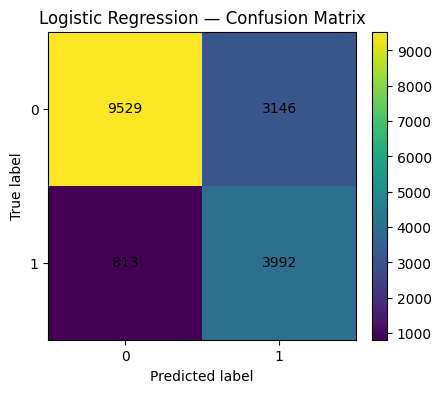

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\logreg_roc_curve.png


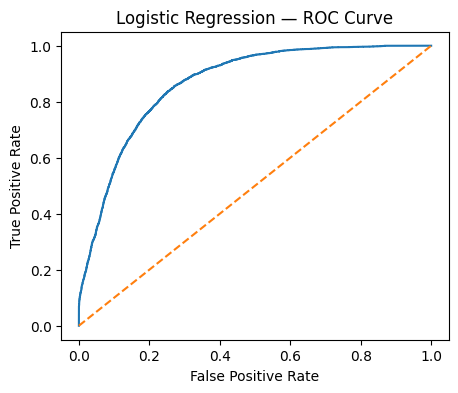

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\logreg_pr_curve.png


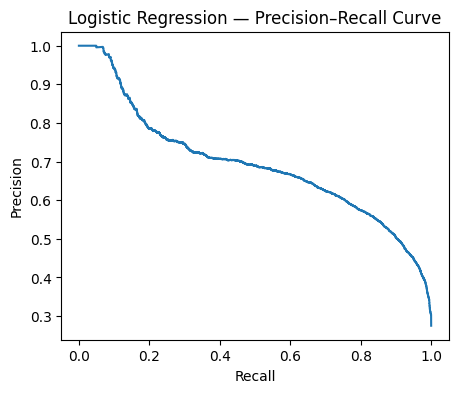

In [73]:
# Confusion matrix heatmap
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm)
ax.set_title("Logistic Regression — Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["0", "1"]); ax.set_yticklabels(["0", "1"])

for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
out_cm = ART["plots"] / "logreg_confusion_matrix.png"
fig.savefig(out_cm, dpi=150, bbox_inches="tight")
print("Saved:", out_cm.resolve())
plt.show()
plt.close(fig)

# Probability curves
if y_proba is not None:
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_title("Logistic Regression — ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    out_roc = ART["plots"] / "logreg_roc_curve.png"
    fig.savefig(out_roc, dpi=150, bbox_inches="tight")
    print("Saved:", out_roc.resolve())
    plt.show()
    plt.close(fig)

    # PR
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(rec, prec)
    ax.set_title("Logistic Regression — Precision–Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    out_pr = ART["plots"] / "logreg_pr_curve.png"
    fig.savefig(out_pr, dpi=150, bbox_inches="tight")
    print("Saved:", out_pr.resolve())
    plt.show()
    plt.close(fig)
else:
    print("ROC/PR curves skipped: predict_proba not available.")


## Threshold analysis

Logistic Regression produces probabilities, so the decision threshold can be tuned.
This section evaluates thresholds from 0.05 to 0.95 and saves:
- threshold metrics table
- F1 vs threshold plot
- precision/recall vs threshold plot


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\metrics\logreg_threshold_metrics.csv


,threshold,precision,recall,f1
0,0.05,0.328051,0.995213,0.493448
1,0.10,0.359574,0.989594,0.527483
2,0.15,0.389333,0.982934,0.557747
3,0.20,0.415812,0.969823,0.582063
4,0.25,0.438668,0.957128,0.601609
5,0.30,0.459994,0.939230,0.617542
6,0.35,0.483022,0.920708,0.633629
7,0.40,0.507349,0.898023,0.648385
8,0.45,0.530757,0.869095,0.659039
9,0.50,0.559260,0.830801,0.668509


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\logreg_threshold_f1.png


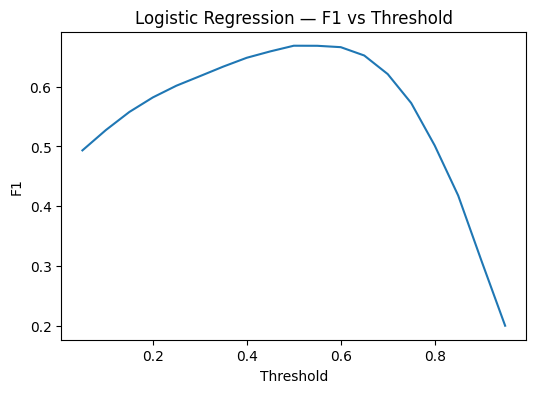

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\logreg_threshold_precision_recall.png


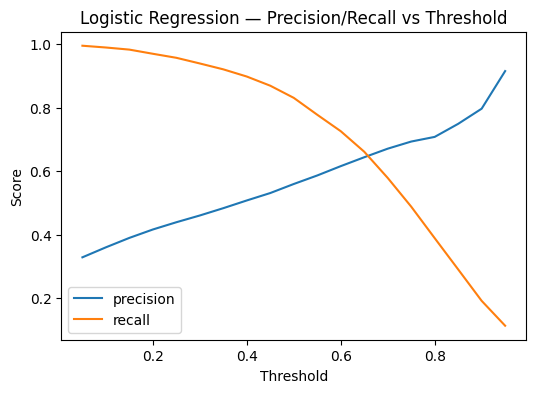

In [74]:
if y_proba is None:
    print("Threshold analysis skipped: predict_proba not available.")
else:
    thresholds = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in thresholds:
        pred_t = (y_proba >= t).astype(int)
        rows.append({
            "threshold": float(t),
            "precision": float(precision_score(y_test, pred_t, zero_division=0)),
            "recall": float(recall_score(y_test, pred_t, zero_division=0)),
            "f1": float(f1_score(y_test, pred_t, zero_division=0)),
        })

    thr_df = pd.DataFrame(rows)
    save_dataframe(thr_df, ART["metrics"] / "logreg_threshold_metrics.csv", index=False)
    print("Saved:", (ART["metrics"] / "logreg_threshold_metrics.csv").resolve())
    display(thr_df)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(thr_df["threshold"], thr_df["f1"])
    ax.set_title("Logistic Regression — F1 vs Threshold")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("F1")
    out_f1 = ART["plots"] / "logreg_threshold_f1.png"
    fig.savefig(out_f1, dpi=150, bbox_inches="tight")
    print("Saved:", out_f1.resolve())
    plt.show()
    plt.close(fig)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(thr_df["threshold"], thr_df["precision"], label="precision")
    ax.plot(thr_df["threshold"], thr_df["recall"], label="recall")
    ax.set_title("Logistic Regression — Precision/Recall vs Threshold")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.legend()
    out_prt = ART["plots"] / "logreg_threshold_precision_recall.png"
    fig.savefig(out_prt, dpi=150, bbox_inches="tight")
    print("Saved:", out_prt.resolve())
    plt.show()
    plt.close(fig)


## Interpretability: coefficient analysis

Coefficient analysis is performed on the fitted model and saved for reporting.
Feature names are extracted from the preprocessing pipeline when available.


In [75]:
def extract_feature_names(preprocess_step) -> list:
    # Expecting: preprocess_step is a Pipeline with a ColumnTransformer under 'transform'
    if hasattr(preprocess_step, "named_steps") and "transform" in preprocess_step.named_steps:
        ct = preprocess_step.named_steps["transform"]
        try:
            return [str(x) for x in ct.get_feature_names_out()]
        except Exception:
            return []
    return []

preprocess_fitted = best_model.named_steps["preprocess"]
model_fitted = best_model.named_steps["model"]

names = extract_feature_names(preprocess_fitted)
coef = np.asarray(model_fitted.coef_).reshape(-1)

if len(names) != len(coef):
    names = [f"f{i}" for i in range(len(coef))]

coef_df = pd.DataFrame({
    "feature": names,
    "coefficient": coef,
    "abs_coefficient": np.abs(coef),
}).sort_values("abs_coefficient", ascending=False)

save_dataframe(coef_df.head(200), ART["metrics"] / "logreg_coefficients_top.csv", index=False)
print("Saved:", (ART["metrics"] / "logreg_coefficients_top.csv").resolve())

top_pos = coef_df.sort_values("coefficient", ascending=False).head(20)
top_neg = coef_df.sort_values("coefficient", ascending=True).head(20)

display(top_pos)
display(top_neg)


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\metrics\logreg_coefficients_top.csv


,feature,coefficient,abs_coefficient
5,f5,2.370302,2.370302
52,f52,1.987588,1.987588
73,f73,1.658276,1.658276
94,f94,1.618888,1.618888
71,f71,1.561738,1.561738
82,f82,1.561337,1.561337
86,f86,1.530339,1.530339
2,f2,1.258430,1.258430
72,f72,1.239336,1.239336
4,f4,1.188264,1.188264


,feature,coefficient,abs_coefficient
15,f15,-3.012655,3.012655
17,f17,-2.894318,2.894318
65,f65,-1.828110,1.828110
79,f79,-1.644324,1.644324
81,f81,-1.477725,1.477725
80,f80,-1.453262,1.453262
66,f66,-1.047570,1.047570
20,f20,-1.038952,1.038952
90,f90,-0.887244,0.887244
89,f89,-0.849710,0.849710


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\logreg_coefficients_positive.png


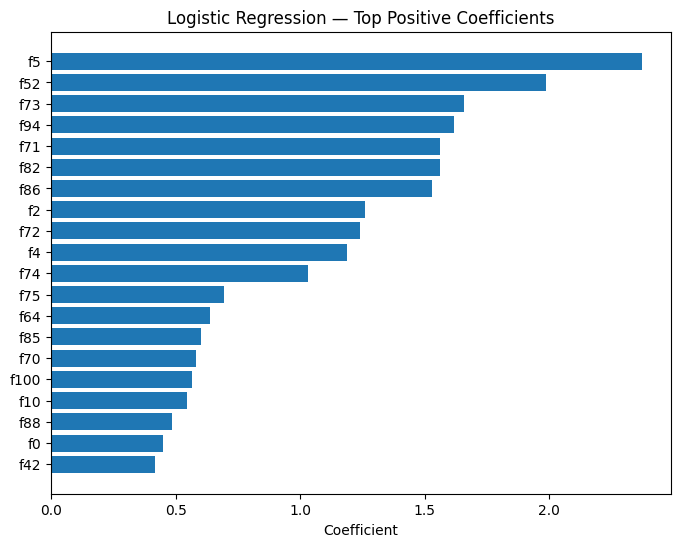

Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\plots\logreg_coefficients_negative.png


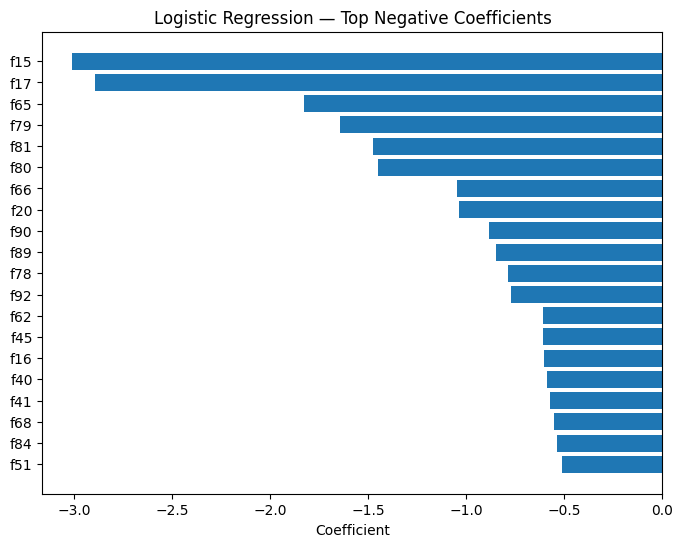

In [76]:
# Positive coefficients
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top_pos["feature"][::-1], top_pos["coefficient"][::-1])
ax.set_title("Logistic Regression — Top Positive Coefficients")
ax.set_xlabel("Coefficient")
out_pos = ART["plots"] / "logreg_coefficients_positive.png"
fig.savefig(out_pos, dpi=150, bbox_inches="tight")
print("Saved:", out_pos.resolve())
plt.show()
plt.close(fig)

# Negative coefficients
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top_neg["feature"][::-1], top_neg["coefficient"][::-1])
ax.set_title("Logistic Regression — Top Negative Coefficients")
ax.set_xlabel("Coefficient")
out_neg = ART["plots"] / "logreg_coefficients_negative.png"
fig.savefig(out_neg, dpi=150, bbox_inches="tight")
print("Saved:", out_neg.resolve())
plt.show()
plt.close(fig)


## Report notes (model justification)

This file is intended to be copied into the final report section for the Logistic Regression baseline.
Update the placeholders after reviewing the saved metrics and plots.


In [77]:
notes = [
    "Logistic Regression (baseline) — report notes",
    "",
    "Modeling decisions:",
    "- Leakage columns removed before training.",
    "- Missing values imputed; categoricals one-hot encoded; numeric features scaled.",
    "- Regularization tuned using stratified cross-validation with F1 selection.",
    "",
    "Findings to report:",
    "- CV results: include best mean F1 and parameter settings.",
    "- Test metrics: include F1, precision, recall, ROC-AUC, PR-AUC (if computed).",
    "- Threshold analysis: report whether a threshold other than 0.50 improves the target metric.",
    "- Interpretability: discuss the most influential positive/negative coefficients.",
]

out_path = ART["reports"] / "logreg_notes.md"
save_text("\n".join(notes), out_path)
print("Saved:", out_path.resolve())
display(pd.DataFrame({"LogReg report notes": notes}))


Saved: D:\SLIIT\Y4S2\IT4060 - Machine Learning\Assignment\repo\Machine-Learning-Assignment\artifacts\reports\logreg_notes.md


,LogReg report notes
0,Logistic Regression (baseline) — report notes
1,
2,Modeling decisions:
3,- Leakage columns removed before training.
4,- Missing values imputed; categoricals one-hot...
5,- Regularization tuned using stratified cross-...
6,
7,Findings to report:
8,- CV results: include best mean F1 and paramet...
9,"- Test metrics: include F1, precision, recall,..."


## Saved artifacts summary

This section lists key files expected after a successful run.


In [78]:
paths = [
    ART["models"] / "logreg_pipeline.joblib",
    ART["metrics"] / "logreg_cv_results.csv",
    ART["metrics"] / "logreg_best_params.json",
    ART["metrics"] / "logreg_test_metrics.json",
    ART["metrics"] / "logreg_threshold_metrics.csv",
    ART["metrics"] / "logreg_coefficients_top.csv",
    ART["plots"] / "logreg_confusion_matrix.png",
    ART["plots"] / "logreg_roc_curve.png",
    ART["plots"] / "logreg_pr_curve.png",
    ART["plots"] / "logreg_threshold_f1.png",
    ART["plots"] / "logreg_threshold_precision_recall.png",
    ART["plots"] / "logreg_coefficients_positive.png",
    ART["plots"] / "logreg_coefficients_negative.png",
    ART["reports"] / "logreg_classification_report.txt",
    ART["reports"] / "logreg_notes.md",
]
display(pd.DataFrame([{"path": str(p), "exists": p.exists()} for p in paths]))


,path,exists
0,artifacts\models\logreg_pipeline.joblib,True
1,artifacts\metrics\logreg_cv_results.csv,True
2,artifacts\metrics\logreg_best_params.json,True
3,artifacts\metrics\logreg_test_metrics.json,True
4,artifacts\metrics\logreg_threshold_metrics.csv,True
5,artifacts\metrics\logreg_coefficients_top.csv,True
6,artifacts\plots\logreg_confusion_matrix.png,True
7,artifacts\plots\logreg_roc_curve.png,True
8,artifacts\plots\logreg_pr_curve.png,True
9,artifacts\plots\logreg_threshold_f1.png,True


## Results discussion (Logistic Regression)

This section summarizes the outcomes from the trained Logistic Regression baseline and provides report-ready interpretations.

Key points to include in the report:

- **Cross-validation performance**  
  The best configuration is selected using mean cross-validated **F1 score**. Report:
  - best mean CV F1 (and standard deviation)
  - selected hyperparameters (`C`, `l1_ratio`, and `class_weight`)
  - brief justification for using F1 (balances precision and recall under class imbalance)

- **Test-set performance**  
  Report the test metrics saved in `artifacts/metrics/logreg_test_metrics.json`:
  - F1, Precision, Recall, Balanced Accuracy  
  - ROC-AUC and PR-AUC (probability-based discrimination)  
  - Log loss (probability calibration check, lower is better)

- **Error profile (confusion matrix)**  
  Use the saved confusion matrix plot to describe:
  - whether the model produces more false positives or false negatives  
  - why that outcome matters for hotel cancellations (cost of over-predicting vs under-predicting cancellations)

- **Threshold analysis**  
  If `artifacts/metrics/logreg_threshold_metrics.csv` is available:
  - identify the threshold that maximizes F1 (or another objective chosen for the project)  
  - describe the precision–recall trade-off when moving the threshold  
  - justify whether the default threshold (0.50) is appropriate

- **Interpretability (coefficients)**  
  Use the coefficient tables and plots to describe:
  - strongest **positive** coefficients (features associated with increased cancellation risk)
  - strongest **negative** coefficients (features associated with reduced cancellation risk)
  - the limitation that coefficients represent association, not causation

- **Model limitations and next steps**  
  State at least two limitations and two improvements, for example:
  - non-linear interactions may not be captured well by a linear model  
  - rare categories may be underrepresented after encoding  
  - next steps: compare against tree-based models, add calibrated probabilities, inspect feature interactions, or refine feature engineering

The notebook artifacts already contain the tables and figures required to support this discussion in the final report.


In [79]:
# Auto-summary table (generated from saved artifacts)
# This cell loads the saved metrics and produces a compact report-ready summary.

import json
from pathlib import Path
import pandas as pd

metrics_path = ART["metrics"] / "logreg_test_metrics.json"
best_params_path = ART["metrics"] / "logreg_best_params.json"
cv_path = ART["metrics"] / "logreg_cv_results.csv"
thr_path = ART["metrics"] / "logreg_threshold_metrics.csv"

summary = {}

if best_params_path.exists():
    summary["best_params"] = json.loads(best_params_path.read_text(encoding="utf-8"))

if metrics_path.exists():
    summary["test_metrics"] = json.loads(metrics_path.read_text(encoding="utf-8"))

if cv_path.exists():
    cv_df = pd.read_csv(cv_path)
    summary["best_cv_row"] = cv_df.iloc[0].to_dict()

display(pd.DataFrame([{
    "best_cv_f1_mean": summary.get("best_cv_row", {}).get("cv_f1_mean", None),
    "best_cv_f1_std": summary.get("best_cv_row", {}).get("cv_f1_std", None),
    "test_f1": summary.get("test_metrics", {}).get("f1", None),
    "test_precision": summary.get("test_metrics", {}).get("precision", None),
    "test_recall": summary.get("test_metrics", {}).get("recall", None),
    "test_balanced_accuracy": summary.get("test_metrics", {}).get("balanced_accuracy", None),
    "test_roc_auc": summary.get("test_metrics", {}).get("roc_auc", None),
    "test_pr_auc": summary.get("test_metrics", {}).get("pr_auc", None),
    "test_log_loss": summary.get("test_metrics", {}).get("log_loss", None),
}]))

if "best_params" in summary:
    display(pd.DataFrame([summary["best_params"]]))

if thr_path.exists():
    thr_df = pd.read_csv(thr_path)
    best_thr = thr_df.sort_values("f1", ascending=False).iloc[0].to_dict()
    display(pd.DataFrame([{
        "best_threshold_by_f1": best_thr.get("threshold"),
        "precision_at_best_threshold": best_thr.get("precision"),
        "recall_at_best_threshold": best_thr.get("recall"),
        "f1_at_best_threshold": best_thr.get("f1"),
    }]))
else:
    print("Threshold metrics file not found. Threshold analysis may have been skipped.")


,best_cv_f1_mean,best_cv_f1_std,test_f1,test_precision,test_recall,test_balanced_accuracy,test_roc_auc,test_pr_auc,test_log_loss
0,0.666642,0.00146,0.668509,0.55926,0.830801,0.791298,0.865841,0.693289,0.461625


,model__C,model__class_weight,model__solver,model__max_iter
0,10.0,balanced,liblinear,2000


,best_threshold_by_f1,precision_at_best_threshold,recall_at_best_threshold,f1_at_best_threshold
0,0.5,0.55926,0.830801,0.668509
